In [8]:
# Importing necessary libraries for data manipulation, plotting, and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time

# Importing Dash components for creating interactive web apps
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Plotly libraries for creating interactive graphs and visualizations
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

# System and traceback libraries for handling errors and system-related operations
import sys
import time
import traceback
import os

# Importing ArduinoCloudClient to interface with Arduino IoT Cloud
from arduino_iot_cloud import ArduinoCloudClient

# Libraries for computer vision tasks
import cv2
from skimage import io

# Library for ML
os.environ["OMP_NUM_THREADS"] = "4"
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure

In [9]:
# Path to the image that will be used in the visualization
image_path = 'Deakin.jpg'

# Lists to store current data and temporary data for processing
current_data = []
temporary_data = []

# Sequence counter to track the order of events or data points
sequence = 0

In [10]:
# Initialize the Dash application
app = dash.Dash(__name__)

# Load and display the image using skimage's io module
image_data = io.imread(image_path)
image_figure = px.imshow(image_data)

# Define the layout of the Dash app with two graphs and an auto-refresh interval
app.layout = html.Div([
    dcc.Graph(id='live-update-graph'),  
    dcc.Graph(id='image-display', figure=image_figure),  
    dcc.Interval(id='interval-component', interval=1000, n_intervals=0)  
])

@app.callback(
    [Output('live-update-graph', 'figure'),
     Output('image-display', 'figure')],
    [Input('interval-component', 'n_intervals')]
)
def update_graph(n_intervals):
    global current_data

    # Convert the data to a DataFrame for visualization
    df = pd.DataFrame(current_data, columns=['index', 'Timestamp', 'X_Acce', 'Y_Acce', 'Z_Acce'])

    # Create a line plot for X, Y, Z values over time using Plotly Express
    line_figure = px.line(df, x='Timestamp', y=['X_Acce', 'Y_Acce', 'Z_Acce'])

    # Reload the image to ensure it's up to date and create a figure
    image_data = io.imread(image_path)
    image_figure = px.imshow(image_data)

    return line_figure, image_figure


In [11]:
app.run_server(debug=True, jupyter_tab=True, port=8001)

In [12]:
# Device credentials for accessing the Arduino IoT Cloud
DEVICE_ID = "d2d8a108-d4c3-4794-bf15-271885269210"
SECRET_KEY = "YyuZ6b3CQZHTJC#TGX@@H7AiP"

# Initialize a dictionary to store file paths
data_ano = {
    'csv_file': [],
    'image_file': []
}

In [13]:
# Variables to store accelerometer data
x, y, z = None, None, None
sample_count = 0
NUM_DATA_SAMPLES = 10  # Number of samples to collect before saving

# Callback functions for accelerometer data changes
def on_accelerometer_x_changed(client, value):
    global x
    x = value

def on_accelerometer_y_changed(client, value):
    global y
    y = value

def on_accelerometer_z_changed(client, value):
    global z
    z = value

# Main function for capturing video and collecting accelerometer data
try:
    # Initialize video capture
    video = cv2.VideoCapture(0)
    
    # Create Arduino IoT Cloud client instance
    client = ArduinoCloudClient(device_id=DEVICE_ID, username=DEVICE_ID, password=SECRET_KEY, sync_mode=True)
    
    # Register callbacks for accelerometer data
    client.register("x", value=None, on_write=on_accelerometer_x_changed)
    client.register("y", value=None, on_write=on_accelerometer_y_changed)
    client.register("z", value=None, on_write=on_accelerometer_z_changed)
    
    # Start the client
    client.start()
    
    # Continuously capture data and frames
    while True:
        # Capture video frame
        success, frame = video.read()
        cv2.namedWindow("Capturing adn Image")
        cv2.imshow('frame', frame)
        
        # Exit on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            video.release()
            cv2.destroyAllWindows()
            break
        
        # If accelerometer data is available
        if x is not None and y is not None and z is not None:
            if sample_count < NUM_DATA_SAMPLES:
                sample_count += 1
                timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
                temporary_data.append([sample_count, timestamp, x, y, z])
                print([sample_count, timestamp, x, y, z])
                
                # Reset accelerometer data
                x, y, z = None, None, None
            else:
                # Save the collected data after NUM_DATA_SAMPLES
                sequence += 1
                timestamp = time.strftime('%Y%m%d-%H%M%S')
                
                # Save data to CSV
                df = pd.DataFrame(temporary_data, columns=['index', 'Timestamp', 'X_Acce', 'Y_Acce', 'Z_Acce'])
                csv_file_name = f"{sequence}_{timestamp}.csv"
                df.to_csv(csv_file_name)
                
                # Save captured image from the video feed
                image_file_name = f"{sequence}_{timestamp}.png"
                if success:
                    cv2.imwrite(image_file_name, frame)
                print("Image captured")
                
                # Update file storage dictionary
                data_ano['csv_file'].append(csv_file_name)
                data_ano['image_file'].append(image_file_name)
                
                # Reset counters and data
                sample_count = 0
                current_data = temporary_data.copy()
                temporary_data.clear()
        
        # Update client to process any new data
        client.update()

except KeyboardInterrupt:
    # Release video capture and close OpenCV windows on exit
    video.release()
    cv2.destroyAllWindows()


[1, '2024-09-21 13:07:43', 0.0519256591796875, 0.0047607421875, -0.9969482421875]
[2, '2024-09-21 13:07:44', 0.051727294921875, 0.0065155029296875, -1.0011444091796875]
[3, '2024-09-21 13:07:45', 0.0509490966796875, 0.0057220458984375, -0.9999847412109375]
[4, '2024-09-21 13:07:46', 0.0522308349609375, 0.00848388671875, -0.9910888671875]
[5, '2024-09-21 13:07:48', 0.05206298828125, 0.00738525390625, -0.9919891357421875]
[6, '2024-09-21 13:07:49', 0.0508880615234375, 0.0062255859375, -0.9981231689453125]
[7, '2024-09-21 13:07:51', 0.0633697509765625, 0.0017547607421875, -1.016998291015625]
[8, '2024-09-21 13:07:52', 0.050872802734375, 0.0065460205078125, -0.9974212646484375]
[9, '2024-09-21 13:07:54', 0.0513153076171875, 0.004974365234375, -1.0006866455078125]
[10, '2024-09-21 13:07:55', 0.049896240234375, 0.004119873046875, -0.998992919921875]
Image captured
[1, '2024-09-21 13:07:56', 0.0521087646484375, 0.0063018798828125, -1.000244140625]
[2, '2024-09-21 13:07:57', 0.0532073974609375

#### Load recorded CSV files and captured Images from the Folder path

In [20]:
# Define the folder paths for CSV and image files
csv_folder_path = r'C:\Users\thinh\Documents\TRIMESTER 2 - 2024\SIT225 - Data Capture Tech\TASK 8.3D\CSV Files'
image_folder_path = r'C:\Users\thinh\Documents\TRIMESTER 2 - 2024\SIT225 - Data Capture Tech\TASK 8.3D\Image Files'

# List all files in the folder path for CSV files and image files
csv_files = os.listdir(csv_folder_path)
image_files = os.listdir(image_folder_path)


csv_files.remove('desktop.ini')
image_files.remove('desktop.ini')

# Sort each file in terms of sequence number
csv_files = sorted(csv_files, key=lambda x: int(x.split('_')[0]))
image_files =  sorted(image_files, key=lambda x: int(x.split('_')[0]))

# Output sorted lists
print("CSV Files:", csv_files)
print("Image Files:", image_files)

CSV Files: ['1_20240921-091831.csv', '2_20240921-091844.csv', '3_20240921-091854.csv', '4_20240921-091905.csv', '5_20240921-091917.csv', '6_20240921-091930.csv', '7_20240921-091940.csv', '8_20240921-091951.csv', '9_20240921-092002.csv', '10_20240921-092014.csv', '11_20240921-092024.csv', '12_20240921-092038.csv', '13_20240921-092049.csv', '14_20240921-092059.csv', '15_20240921-092110.csv', '16_20240921-092122.csv', '17_20240921-092133.csv', '18_20240921-092143.csv', '19_20240921-092157.csv', '20_20240921-092212.csv', '21_20240921-092223.csv', '22_20240921-092233.csv', '23_20240921-092246.csv', '24_20240921-092259.csv', '25_20240921-092309.csv', '26_20240921-092320.csv', '27_20240921-092330.csv', '28_20240921-092343.csv', '29_20240921-092355.csv', '30_20240921-092407.csv', '31_20240921-092419.csv', '32_20240921-092431.csv', '33_20240921-092444.csv', '34_20240921-092455.csv', '35_20240921-092506.csv', '36_20240921-092518.csv', '37_20240921-092530.csv', '38_20240921-092541.csv', '39_20240

#### Convert the files to the DataFrame as well as the images files.

In [21]:
# Create DataFrame with csv_files and image_files
if len(csv_files) == len(image_files):
    csv_image = pd.DataFrame({
        'csv_file': csv_files,
        'image_file': image_files
    })
    print(csv_image)
else:
    print(f"Error: Mismatch in the number of CSV files ({len(csv_files)}) and image files ({len(image_files)})")

                  csv_file              image_file
0    1_20240921-091831.csv   1_20240921-091831.png
1    2_20240921-091844.csv   2_20240921-091844.png
2    3_20240921-091854.csv   3_20240921-091854.png
3    4_20240921-091905.csv   4_20240921-091905.png
4    5_20240921-091917.csv   5_20240921-091917.png
..                     ...                     ...
74  75_20240921-093246.csv  75_20240921-093246.png
75  76_20240921-093257.csv  76_20240921-093257.png
76  77_20240921-093309.csv  77_20240921-093309.png
77  78_20240921-093320.csv  78_20240921-093320.png
78  79_20240921-093331.csv  79_20240921-093331.png

[79 rows x 2 columns]


In [22]:
# Save the dataframe as a CSV file
csv_image.to_csv('csv_image.csv', index = False)

#### Then we need to manually label the activity based on the captured images.

In [24]:
# Load the CSV file
csv_image_df = pd.read_csv('csv_image.csv')
csv_image_df

,csv_file,image_file,Activity
0,1_20240921-091831.csv,1_20240921-091831.png,1
1,2_20240921-091844.csv,2_20240921-091844.png,1
2,3_20240921-091854.csv,3_20240921-091854.png,1
3,4_20240921-091905.csv,4_20240921-091905.png,1
4,5_20240921-091917.csv,5_20240921-091917.png,1
...,...,...,...
74,75_20240921-093246.csv,75_20240921-093246.png,3
75,76_20240921-093257.csv,76_20240921-093257.png,3
76,77_20240921-093309.csv,77_20240921-093309.png,3
77,78_20240921-093320.csv,78_20240921-093320.png,3


#### 1 denotes Waving the phone, 2 is Rotating the phone and 3 is Keeping the phone still. 

#### Merge all the CSV files

In [88]:
folder_path = 'C:/Users/thinh/Documents/TRIMESTER 2 - 2024/SIT225 - Data Capture Tech/TASK 8.3D/CSV Files'  # Folder path

dfs = []  # Initialize a list to store individual DataFrames

# Loop through each CSV file in the folder
for file in csv_files:
    file_path = os.path.join(folder_path, file)  # Get the full file path
    df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
    
    # Find the corresponding row in csv_image_df that matches the current CSV file name
    label_row = csv_image_df[csv_image_df['csv_file'] == file]
    
    if not label_row.empty:  # Ensure that a matching row was found
        df['Activity'] = label_row['Activity'].values[0]  # Add the "Activity" column based on the match
    
    dfs.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames into a single DataFrame
df_combined = pd.concat(dfs, ignore_index=True)  # Combine all DataFrames


In [89]:
df_combined

,Unnamed: 0,index,Timestamp,X_Acce,Y_Acce,Z_Acce,Activity
0,0,1,21/09/2024 9:18,0.335449,-0.186234,-0.946182,1
1,1,2,21/09/2024 9:18,0.324951,-0.175049,-0.913208,1
2,2,3,21/09/2024 9:18,0.227448,-0.228195,-0.932236,1
3,3,4,21/09/2024 9:18,0.330948,-0.242447,-0.930695,1
4,4,5,21/09/2024 9:18,0.369675,-0.519516,-0.870010,1
...,...,...,...,...,...,...,...
785,5,6,2024-09-21 09:33:26,0.053558,0.013916,-0.998520,3
786,6,7,2024-09-21 09:33:27,0.053162,0.013168,-0.999908,3
787,7,8,2024-09-21 09:33:28,0.053146,0.013504,-1.001953,3
788,8,9,2024-09-21 09:33:29,0.050598,0.013611,-1.003082,3


#### Data processing

In [90]:
# Delete unnecessary columns
df_combined.drop(columns = ["Unnamed: 0", "index"], inplace = True)

In [91]:
df_combined

,Timestamp,X_Acce,Y_Acce,Z_Acce,Activity
0,21/09/2024 9:18,0.335449,-0.186234,-0.946182,1
1,21/09/2024 9:18,0.324951,-0.175049,-0.913208,1
2,21/09/2024 9:18,0.227448,-0.228195,-0.932236,1
3,21/09/2024 9:18,0.330948,-0.242447,-0.930695,1
4,21/09/2024 9:18,0.369675,-0.519516,-0.870010,1
...,...,...,...,...,...
785,2024-09-21 09:33:26,0.053558,0.013916,-0.998520,3
786,2024-09-21 09:33:27,0.053162,0.013168,-0.999908,3
787,2024-09-21 09:33:28,0.053146,0.013504,-1.001953,3
788,2024-09-21 09:33:29,0.050598,0.013611,-1.003082,3


In [92]:
# Function to convert timestamps
def convert_timestamp(ts):
    try:
        # Try parsing as ISO format
        return pd.to_datetime(ts)
    except ValueError:
        # If it fails, try parsing as DD/MM/YYYY format
        return pd.to_datetime(ts, format='%d/%m/%Y %H:%M', errors='coerce')
df_combined['Timestamp'] = df_combined['Timestamp'].apply(convert_timestamp)

C:\Users\thinh\AppData\Local\Temp\ipykernel_30548\3565859804.py:5: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [93]:
df_combined

,Timestamp,X_Acce,Y_Acce,Z_Acce,Activity
0,2024-09-21 09:18:00,0.335449,-0.186234,-0.946182,1
1,2024-09-21 09:18:00,0.324951,-0.175049,-0.913208,1
2,2024-09-21 09:18:00,0.227448,-0.228195,-0.932236,1
3,2024-09-21 09:18:00,0.330948,-0.242447,-0.930695,1
4,2024-09-21 09:18:00,0.369675,-0.519516,-0.870010,1
...,...,...,...,...,...
785,2024-09-21 09:33:26,0.053558,0.013916,-0.998520,3
786,2024-09-21 09:33:27,0.053162,0.013168,-0.999908,3
787,2024-09-21 09:33:28,0.053146,0.013504,-1.001953,3
788,2024-09-21 09:33:29,0.050598,0.013611,-1.003082,3


#### Analyse the recorded data

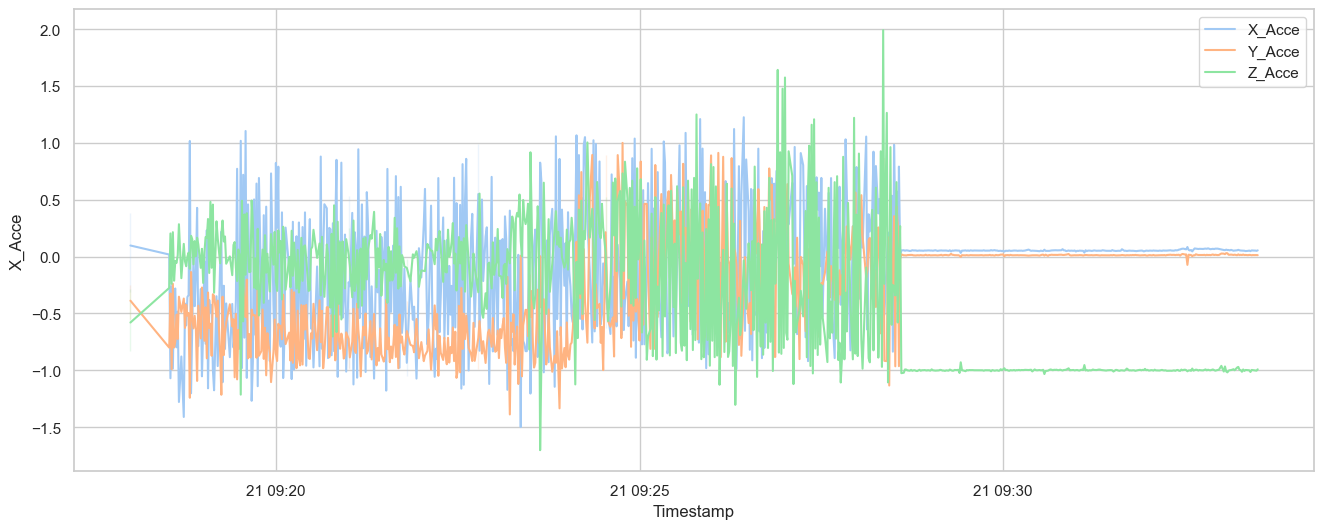

In [94]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
colors = sns.color_palette("pastel")
# Create the line plots with custom colors
sns.lineplot(x=df_combined["Timestamp"], y=df_combined["X_Acce"], label="X_Acce", color=colors[0])
sns.lineplot(x=df_combined["Timestamp"], y=df_combined["Y_Acce"], label="Y_Acce", color=colors[1])
sns.lineplot(x=df_combined["Timestamp"], y=df_combined["Z_Acce"], label="Z_Acce", color=colors[2])

# Add legend and show the plot
plt.legend()
plt.show()

In [95]:
df_combined.set_index('Timestamp', inplace=True)

In [96]:
# Extract different different activites 
df_1 = df_combined.between_time('09:18:00','09:23:00')
df_2 = df_combined.between_time('09:23:00','09:28:00')
df_3 = df_combined.between_time('09:28:00','09:34:00')

#### Activity Plot

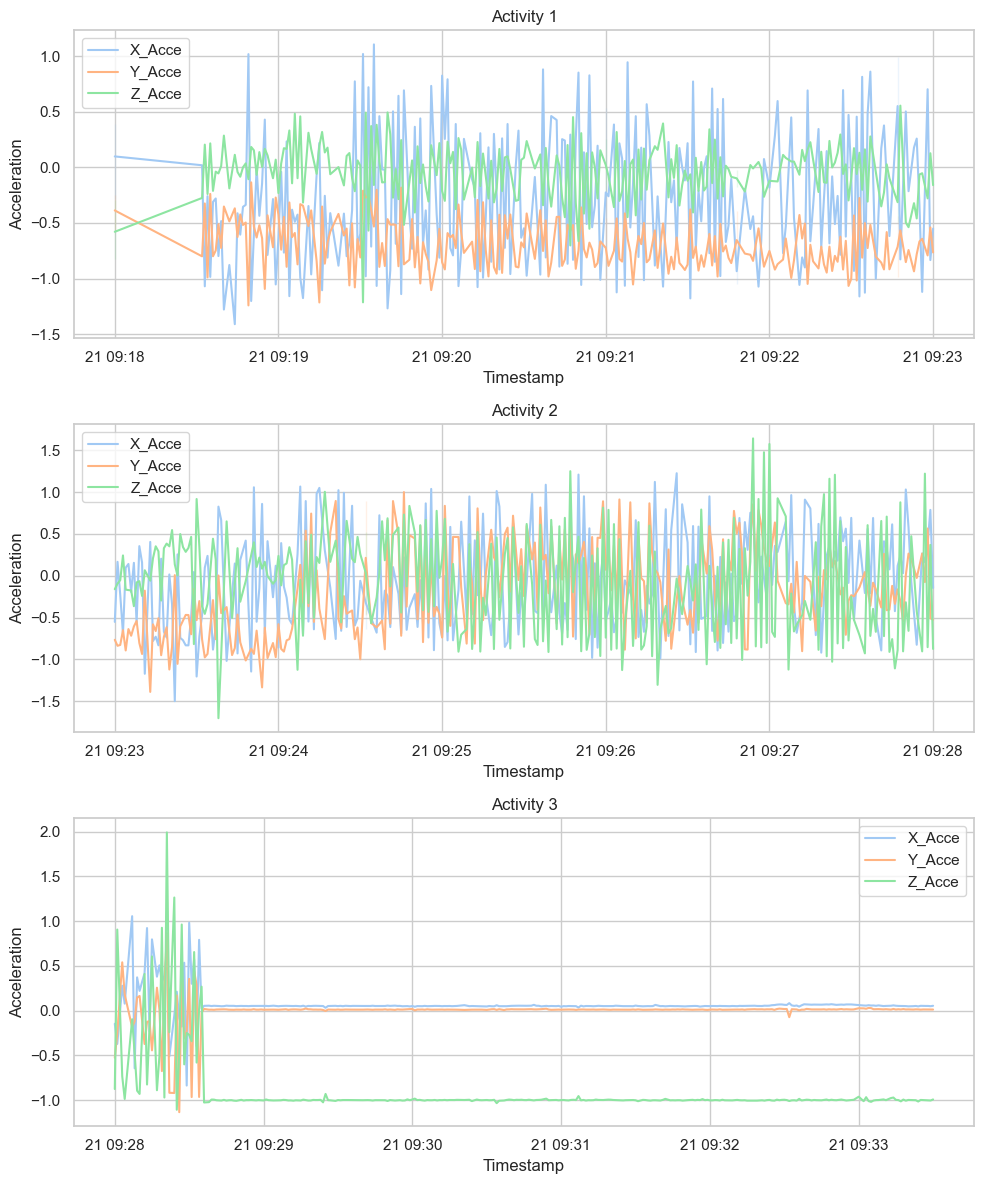

In [97]:
# Set the size of the overall figure
plt.figure(figsize=(10, 12))
sns.set(style="whitegrid")
colors = sns.color_palette("pastel")
# Create subplots for each activity
for i, df in enumerate([df_1, df_2, df_3], start=1):
    plt.subplot(3, 1, i)  # 3 rows, 1 column, i-th subplot
    sns.lineplot(x=df.index, y=df["X_Acce"], label="X_Acce", color=colors[0])
    sns.lineplot(x=df.index, y=df["Y_Acce"], label="Y_Acce", color=colors[1])
    sns.lineplot(x=df.index, y=df["Z_Acce"], label="Z_Acce", color=colors[2])
    
    # Add titles and labels
    plt.title(f'Activity {i}')
    plt.xlabel('Timestamp')
    plt.ylabel('Acceleration')
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### Evaluate whether the recorded data and true labels can be analyzed using a clustering method to identify hidden patterns that correspond to our distinct activities.

In [98]:
df_combined.describe()

,X_Acce,Y_Acce,Z_Acce,Activity
count,790.000000,790.000000,790.000000,790.000000
mean,-0.078446,-0.269130,-0.376946,2.000000
std,0.509973,0.447085,0.599184,0.842472
min,-1.498810,-1.387985,-1.702225,1.000000
25%,-0.448330,-0.654228,-0.996975,1.000000
50%,0.051552,-0.154251,-0.355659,2.000000
75%,0.115944,0.013813,0.104393,3.000000
max,1.225677,1.000290,1.991516,3.000000


In [99]:
features = df_combined[['X_Acce', 'Y_Acce', 'Z_Acce']]
y_encoded = df_combined['Activity']  #  ground truth labels

In [100]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=1)
df_combined['Cluster'] = kmeans.fit_predict(features)

C:\Users\thinh\Documents\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



In [104]:
ari = adjusted_rand_score(y_encoded, df_combined['Cluster'])
print(f"Adjusted Rand Index (ARI): {ari}")

ami = adjusted_mutual_info_score(y_encoded, df_combined['Cluster'])
print(f"Adjusted Mutual Information (AMI): {ami}")

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y_encoded, df_combined['Cluster'])
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Adjusted Rand Index (ARI): 0.47350549768854994
Adjusted Mutual Information (AMI): 0.4364058593156919
Homogeneity: 0.41272504688775635
Completeness: 0.46610977561506733
V-Measure: 0.43779598638958606


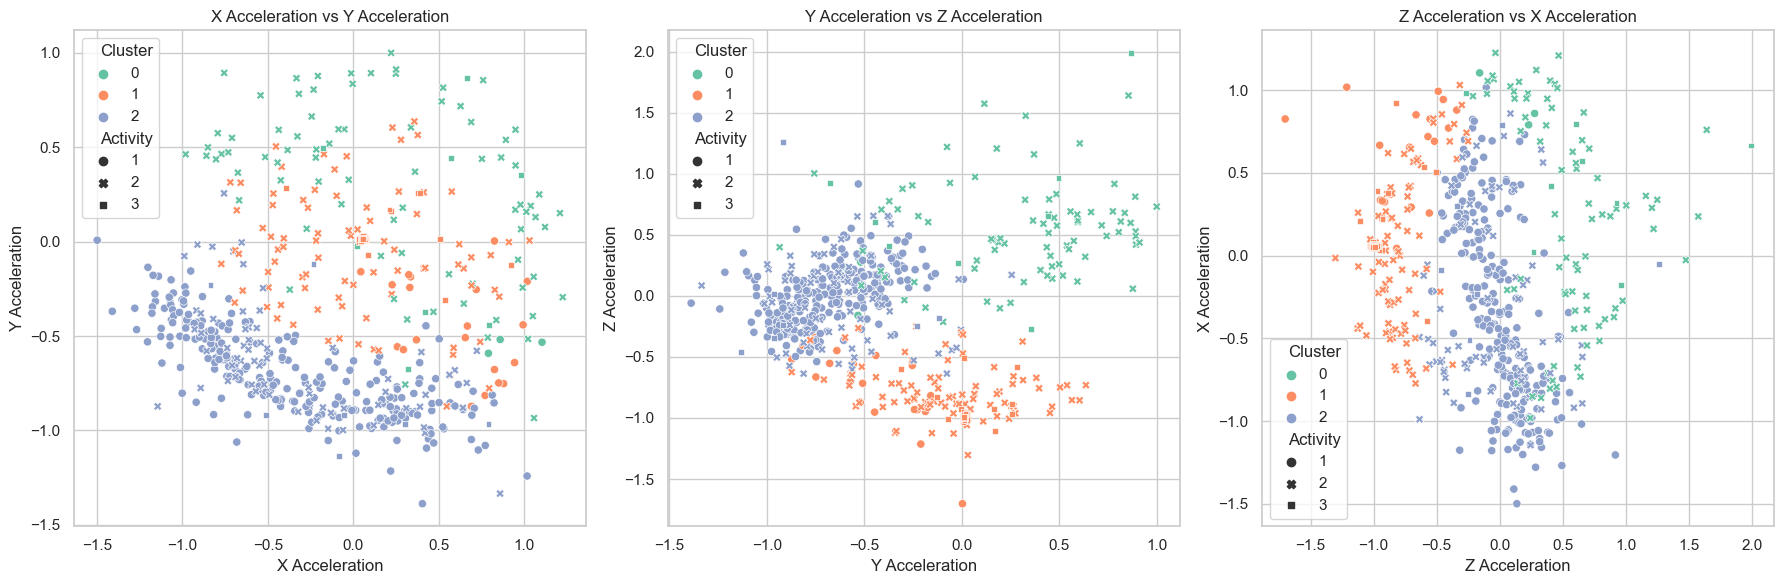

In [105]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot X_Acce vs Y_Acce
sns.scatterplot(data=df_combined, x='X_Acce', y='Y_Acce', hue='Cluster', palette='Set2', style='Activity', ax=axs[0])
axs[0].set_title('X Acceleration vs Y Acceleration')
axs[0].set_xlabel('X Acceleration')
axs[0].set_ylabel('Y Acceleration')

# Scatter plot Y_Acce vs Z_Acce
sns.scatterplot(data=df_combined, x='Y_Acce', y='Z_Acce', hue='Cluster', palette='Set2', style='Activity', ax=axs[1])
axs[1].set_title('Y Acceleration vs Z Acceleration')
axs[1].set_xlabel('Y Acceleration')
axs[1].set_ylabel('Z Acceleration')

# Scatter plot Z_Acce vs X_Acce
sns.scatterplot(data=df_combined, x='Z_Acce', y='X_Acce', hue='Cluster', palette='Set2', style='Activity', ax=axs[2])
axs[2].set_title('Z Acceleration vs X Acceleration')
axs[2].set_xlabel('Z Acceleration')
axs[2].set_ylabel('X Acceleration')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()